# Generalized pooling through interpolation

1. Compute interpolation weights between any two spherical samplings with [CDO](https://code.mpimet.mpg.de/projects/cdo) (through [SCRIP](https://github.com/SCRIP-Project/SCRIP/wiki/SCRIP-User-Guide) or [YAC](https://dkrz-sw.gitlab-pages.dkrz.de/yac/)).
    * When downsampling, conservative interpolation (i.e., that preserve the integral) best represent the finer grid.
    * When upsampling, conservative interpolation will keep the piece-wise constant structure of the coarser grid. Bilinear will be smoother. See a [comparison](https://pangeo-xesmf.readthedocs.io/en/latest/notebooks/Compare_algorithms.html).
2. Use these weights to pool and unpool in pytorch by a multiplication with a sparse matrix.
    * These weights are also used to remap ERA5 to any of our spherical samplings (from an N320 Gaussian grid).

In [1]:
import sys

import numpy as np
from scipy import sparse
from matplotlib import pyplot as plt
import pygsp as pg

sys.path.insert(0, '..')
from modules import remap

In [2]:
# Run cdo from conda environment from a jupyter that is not in the environment.
# import os, subprocess
# cdo = os.path.join(sys.exec_prefix, 'bin/cdo')
# p = subprocess.run([cdo, '-V'], stderr=subprocess.PIPE)
# print(p.stderr)

In [3]:
# Graphs to remap to (pool and unpool to).
graph1 = pg.graphs.SphereHealpix(subdivisions=2, nest=True, k=4, kernel_width=None)
graph2 = pg.graphs.SphereHealpix(subdivisions=1, nest=True, k=4, kernel_width=None)

## Get true HEALPix pixels (not Voronoi cells) for verification

Update `SphericalVoronoiMesh_from_pygsp` (in `remap.py`) with the below.

In [4]:
graph = graph2
radius = 1

def xyz2lonlat(x,y,z, radius=6371.0e6):
    """From cartesian geocentric coordinates to 2D geographic coordinates."""
    latitude = np.arcsin(z / radius)/np.pi*180
    longitude = np.arctan2(y, x)/np.pi*180
    return longitude, latitude 

# Hack to get HEALPix true vertices (quadrilateral polygons).
import healpy as hp
npix = graph.n_vertices
nside = np.sqrt(npix/12)
step = 8  # number of vertices per edge (edges are not geodesics)
vertices = hp.boundaries(nside, range(npix), nest=graph.nest, step=step)
assert vertices.shape == (npix, 3, 4*step)
list_polygons_lonlat = []
for tmp_xyz in vertices:
    tmp_lon, tmp_lat = xyz2lonlat(tmp_xyz[0],tmp_xyz[1],tmp_xyz[2], radius=radius)
    list_polygons_lonlat.append(np.column_stack((tmp_lon, tmp_lat)))

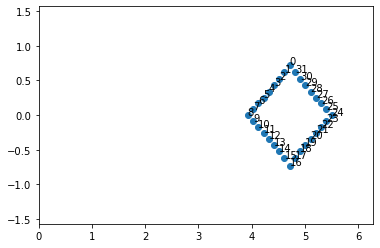

In [5]:
# HEALPix vertices are ordered counter-clockwise.
vertex = vertices[7]
lat, lon = pg.utils.xyz2latlon(vertex[0], vertex[1], vertex[2])
plt.scatter(lon, lat)
plt.xlim(0, 2*np.pi)
plt.ylim(-np.pi/2, np.pi/2)
for i, (lon_i, lat_i) in enumerate(zip(lon, lat)):
    plt.text(lon_i, lat_i, i)

## Get interpolation (remapping) weights

In [6]:
remap.get_available_interp_methods()

['nearest_neighbors',
 'idw',
 'bilinear',
 'bicubic',
 'conservative',
 'conservative_SCRIP',
 'conservative2',
 'largest_area_fraction']

In [7]:
remap.compute_interpolation_weights(graph1, graph2, method='conservative', normalization='fracarea') # destarea’

<xarray.Dataset>
Dimensions:              (dst_grid_corners: 6, dst_grid_rank: 1, dst_grid_size: 12, num_links: 80, num_wgts: 1, src_grid_corners: 7, src_grid_rank: 1, src_grid_size: 48)
Dimensions without coordinates: dst_grid_corners, dst_grid_rank, dst_grid_size, num_links, num_wgts, src_grid_corners, src_grid_rank, src_grid_size
Data variables:
    src_grid_dims        (src_grid_rank) int32 ...
    dst_grid_dims        (dst_grid_rank) int32 ...
    src_grid_center_lat  (src_grid_size) float64 ...
    dst_grid_center_lat  (dst_grid_size) float64 ...
    src_grid_center_lon  (src_grid_size) float64 ...
    dst_grid_center_lon  (dst_grid_size) float64 ...
    src_grid_corner_lat  (src_grid_size, src_grid_corners) float64 ...
    src_grid_corner_lon  (src_grid_size, src_grid_corners) float64 ...
    dst_grid_corner_lat  (dst_grid_size, dst_grid_corners) float64 ...
    dst_grid_corner_lon  (dst_grid_size, dst_grid_corners) float64 ...
    src_grid_imask       (src_grid_size) int32 ...
    dst_grid_imask       (dst_grid_size) int32 ...
    src_grid_area        (src_grid_size) float64 ...
    dst_grid_area        (dst_grid_size) float64 ...
    src_grid_frac        (src_grid_size) float64 ...
    dst_grid_frac        (dst_grid_size) float64 ...
    src_address          (num_links) int32 ...
    dst_address          (num_links) int32 ...
    remap_matrix         (num_links, num_wgts) float64 ...
Attributes:
    title:          SCRIP remapping with CDO
    normalization:  fracarea
    map_method:     Conservative remapping using clipping on sphere
    conventions:    SCRIP
    source_grid:    unstructured
    dest_grid:      unstructured
    history:        15 Mar 2021 : cdo -b 64 genycon,/tmp/dst_CDO_grid_ypnubqk...
    CDO:            Climate Data Operators version 1.9.9 (https://mpimet.mpg....

## Build interpolation (pooling) matrices

In [8]:
def build_interpolation_matrix(src_graph, dst_graph):
    """Return the sparse matrix that interpolates between two spherical samplings."""

    ds = remap.compute_interpolation_weights(src_graph, dst_graph, method='conservative', normalization='fracarea') # destarea’

    # Sanity checks.
    np.testing.assert_allclose(ds.src_grid_center_lat, src_graph.signals['lat'])
    np.testing.assert_allclose(ds.src_grid_center_lon, src_graph.signals['lon'])
    np.testing.assert_allclose(ds.dst_grid_center_lat, dst_graph.signals['lat'])
    np.testing.assert_allclose(ds.dst_grid_center_lon, dst_graph.signals['lon'])
    np.testing.assert_allclose(ds.src_grid_frac, 1)
    np.testing.assert_allclose(ds.dst_grid_frac, 1)
    np.testing.assert_allclose(ds.src_grid_imask, 1)
    np.testing.assert_allclose(ds.dst_grid_imask, 1)

    col = ds.src_address
    row = ds.dst_address
    dat = ds.remap_matrix.squeeze()
    # CDO indexing starts at 1
    row = np.array(row) - 1
    col = np.array(col) - 1
    weights = sparse.csr_matrix((dat, (row, col)))
    assert weights.shape == (dst_graph.n_vertices, src_graph.n_vertices)

    # Destination pixels are normalized to 1 (row-sum = 1).
    # Weights represent the fractions of area attributed to source pixels.
    np.testing.assert_allclose(weights.sum(axis=1), 1)
    # Interpolation is conservative: it preserves area.
    np.testing.assert_allclose(weights.T @ ds.dst_grid_area, ds.src_grid_area)

    # Unnormalize.
    weights = weights.multiply(ds.dst_grid_area.values[:, np.newaxis])

    # Another way to assert that the interpolation is conservative.
    np.testing.assert_allclose(np.asarray(weights.sum(1)).squeeze(), ds.dst_grid_area)
    np.testing.assert_allclose(np.asarray(weights.sum(0)).squeeze(), ds.src_grid_area)

    return weights

def build_pooling_matrices(weights):
    """Normalize interpolation matrix for pooling and unpooling."""
    pool = weights.multiply(1/weights.sum(1))
    unpool = weights.multiply(1/weights.sum(0)).T
    return pool, unpool

weights = build_interpolation_matrix(graph1, graph2)
pool, unpool = build_pooling_matrices(weights)

# Check normalization.
np.testing.assert_allclose(pool.sum(1), 1)
np.testing.assert_allclose(unpool.sum(1), 1)

## Analyze the interpolation matrices

* Can be seen as a bipartite graph made of source and destination pixels.
* Entries (edge weights) are the overlapping areas between source and destination pixels.
    * The row-sum is the areas of destination pixels.
    * The column-sum is the areas of source pixels.
* Matrix can be row- (destination areas equal 1) or column-normalized (source areas equal 1).
    * Row-normalize: pooling matrix.
    * Column-normalize: unpooling matrix.

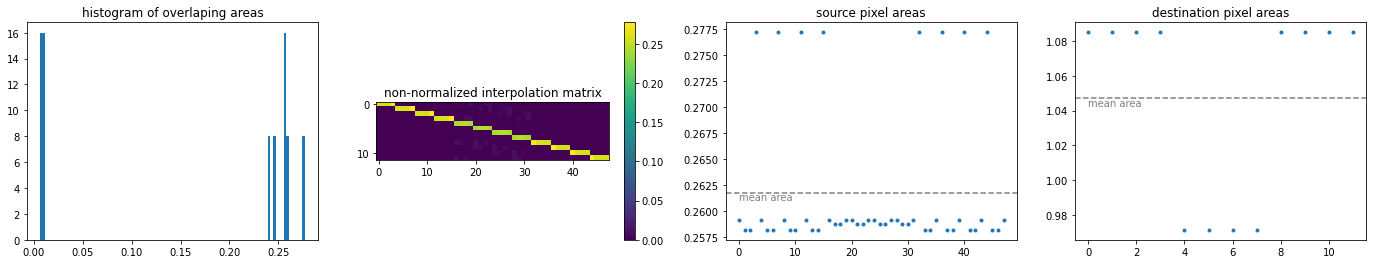

In [9]:
def plot_interpolation_matrix(weights):

    fig, axes = plt.subplots(1, 4, figsize=(24, 4))
    axes[0].hist(weights.data, bins=100)
    axes[0].set_title('histogram of overlaping areas')
    im = axes[1].imshow(weights.toarray())
    fig.colorbar(im, ax=axes[1])
    axes[1].set_title('non-normalized interpolation matrix')

    def plot_area(area, name, ax):
        ax.plot(area, '.')
        assert np.allclose(area.mean(), 4*np.pi / len(area))
        ax.axhline(area.mean(), ls='--', c='grey')
        ax.text(0, area.mean(), 'mean area', c='grey', va='top')
        ax.set_title(f'{name} pixel areas')

    area_src = weights.sum(0)
    area_dst = weights.sum(1)
    plot_area(area_src.T, 'source', axes[2])
    plot_area(area_dst, 'destination', axes[3])

plot_interpolation_matrix(weights)

* Close to the 4x 0.25 of average pooling on HEALPix with pixels subdivided into 4 (not Voronoi).
* Almost all ones, because most pixels are simply included in a parent.
  That is true of the true HEALPix pixels, less so for Voronoi.

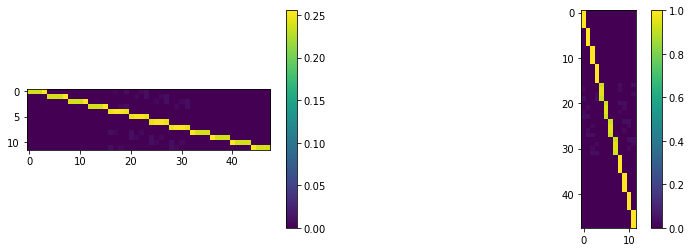

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
im = axes[0].imshow(pool.toarray())
fig.colorbar(im, ax=axes[0])
im = axes[1].imshow(unpool.toarray())
fig.colorbar(im, ax=axes[1])

## When is interpolation invertible?

* Unpooling then pooling can be non-destructive (no loss of information).
    * `pool @ unpool = I` when the bipartite interpolation graph is disconnected, i.e., parent vertices have disjoint supports.
    * In which case `pool` is the [Moore–Penrose inverse](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse) of `unpool`.
* Pooling then unpooling is necessarily destructive (reduction of degrees of freedom).
    * `unpool @ pool` should be a block-diagonal (averaging over pooled vertices) matrix if all pixels are included in a single parent (and properly ordered).
    * Should `unpool` be the Moore–Penrose inverse of `pool`?

The two above work for true HEALPix pixels (not the Voronoi cells), with pooling `[0.25, 0.25, 0.25, 0.25]` and unpooling `[1, 1, 1, 1]`, because that sampling scheme is exactly hierarchical.

Can we use this to evaluate the quality of a coarsening/interpolation or of a (hierarchical) sampling?
* Can look at `1 - np.diag(pool @ unpool)` (as the row-sum is one, that is also the sum of off-diagonal elements).
* `np.sum(1 - np.diag(pool @ unpool)) / npix` is the fraction of averaged/mixed pixel values.

In [11]:
def example(weights):
    unpool = (weights / weights.sum(0)).T
    pool = weights / weights.sum(1)[:, np.newaxis]

    print(unpool)
    print(pool)

    print(pool @ unpool)
    print(unpool @ pool)

print('Is invertible:')
example(np.array([
    [1, 3, 0, 0],
    [0, 0, 3, 1],
]))
print('Is not invertible:')
example(np.array([
    [1, 3, 0, 0],
    [0, 1, 3, 1],
]))

Is invertible:
[[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
[[0.25 0.75 0.   0.  ]
 [0.   0.   0.75 0.25]]
[[1. 0.]
 [0. 1.]]
[[0.25 0.75 0.   0.  ]
 [0.25 0.75 0.   0.  ]
 [0.   0.   0.75 0.25]
 [0.   0.   0.75 0.25]]
Is not invertible:
[[1.   0.  ]
 [0.75 0.25]
 [0.   1.  ]
 [0.   1.  ]]
[[0.25 0.75 0.   0.  ]
 [0.   0.2  0.6  0.2 ]]
[[0.8125 0.1875]
 [0.15   0.85  ]]
[[0.25   0.75   0.     0.    ]
 [0.1875 0.6125 0.15   0.05  ]
 [0.     0.2    0.6    0.2   ]
 [0.     0.2    0.6    0.2   ]]


In [12]:
def plot_matrices(mat1, mat2, axes=None):
    if sparse.issparse(mat1):
        mat1 = mat1.toarray()
    if sparse.issparse(mat2):
        mat2 = mat2.toarray()
    if axes is None:
        fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    im = axes[0].imshow(mat1)
    axes[0].figure.colorbar(im, ax=axes[0])
    im = axes[1].imshow(mat2)
    axes[1].figure.colorbar(im, ax=axes[1])

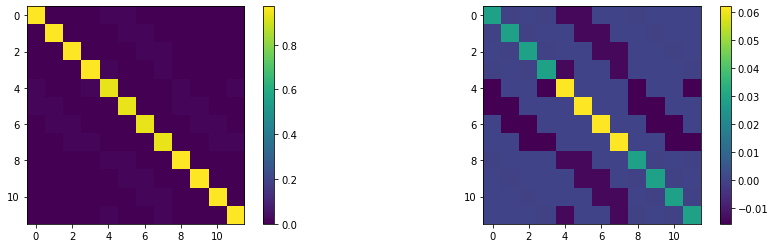

In [13]:
p = pool @ unpool

# Only if non-destructive.
# assert np.allclose(p, np.identity(graph2.N), atol=1e-10)

err = np.identity(graph2.N) - p
plot_matrices(p.toarray(), err)

# Another way to see the error.
# pool_pinv = np.linalg.pinv(unpool.toarray())
# assert np.allclose(pool_pinv @ unpool, np.identity(graph2.n_vertices), atol=1e-10)
# err = pool.toarray() - pool_pinv
# plot_matrices(pool_pinv, err)

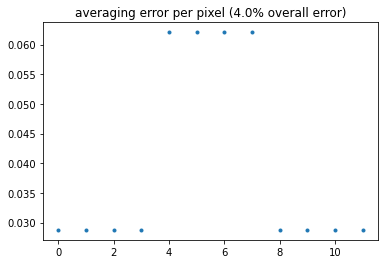

In [14]:
def plot_inversion_error(pool, unpool, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    # diag = np.diag((pool @ unpool).toarray()
    diag = pool.multiply(unpool.T).sum(1)
    err = 1 - diag
    ax.plot(err, '.')
    err = np.sum(err) / len(err)
    ax.set_title(f'averaging error per pixel ({err:.1%} overall error)')

plot_inversion_error(pool, unpool)

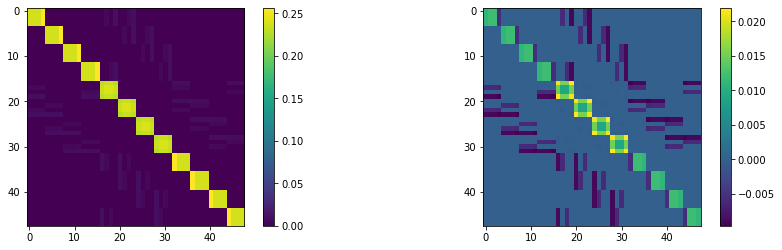

In [15]:
p = unpool @ pool

def block_diag(blocksize, nblock):
    block = np.ones((int(blocksize), int(blocksize))) / blocksize
    return sparse.block_diag([block]*nblock)

# Only a true error for the original HEALPix pixels. Not the Voronoi ones (which may overlap).
err = block_diag(int(graph1.n_vertices / graph2.n_vertices), graph2.n_vertices) - p

plot_matrices(p.toarray(), err.toarray())

# Another way to see the error.
# unpool_pinv = np.linalg.pinv(pool.toarray())
# err = unpool.toarray() - unpool_pinv
# plot_matrices(unpool_pinv, err)

## Laplacian coarsening

* And preservation of its action and spectral properties.
* See also [Spectrally approximating large graphs with smaller graphs](https://arxiv.org/abs/1802.07510).

In [16]:
# graph1 = pg.graphs.SphereHealpix(subdivisions=8, nest=False, k=20, kernel_width=None)
# graph2 = pg.graphs.SphereHealpix(subdivisions=2, nest=False, k=20, kernel_width=None)
# weights = build_interpolation_matrix(graph1, graph2)
# pool, unpool = build_pooling_matrices(weights)

In [17]:
def plot_laplacians(L, graph):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    err = L - graph.L
    plot_matrices(L, err, axes)
    graph.compute_fourier_basis()
    e, U = np.linalg.eigh(L.toarray())
    axes[2].plot(graph.e, '.-', label='original')
    axes[2].plot(e, '.-', label='reconstructed')
    axes[2].legend()

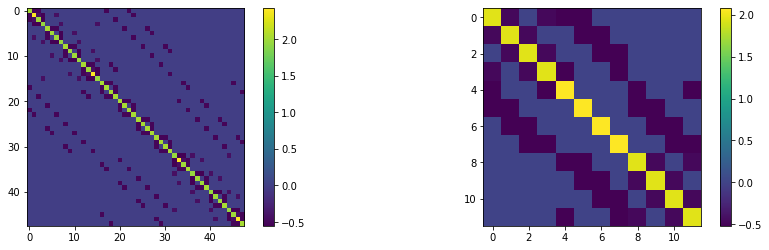

In [18]:
plot_matrices(graph1.L, graph2.L)

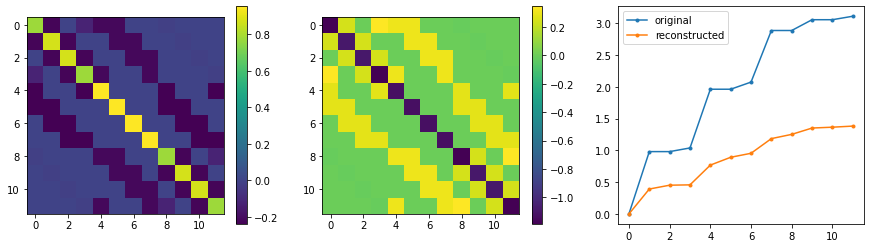

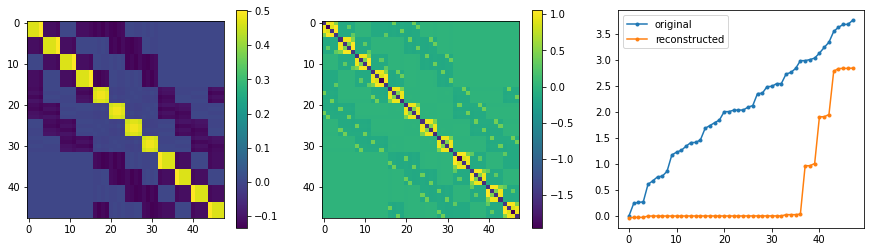

In [19]:
# Processing on a graph of lower or higher resolution.
# TODO: a scaling factore is missing.
plot_laplacians(pool @ graph1.L @ unpool, graph2)
plot_laplacians(unpool @ graph2.L @ pool, graph1)

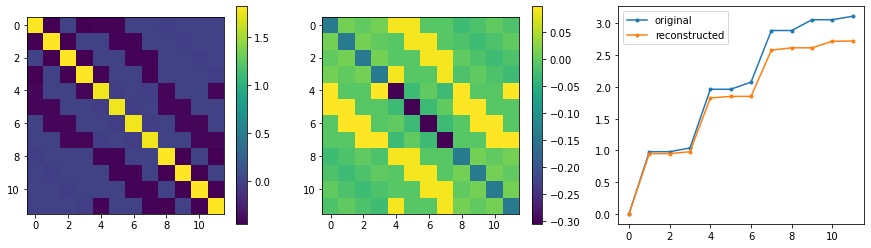

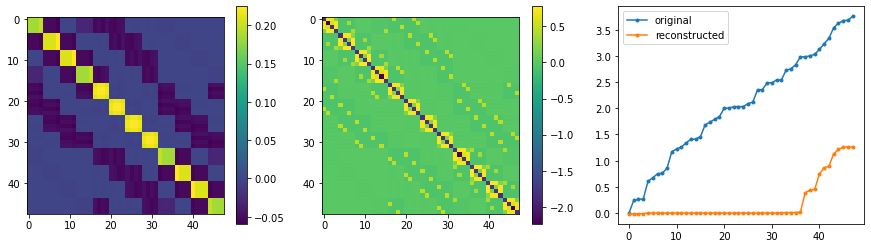

In [20]:
# Graph compression.
plot_laplacians(pool @ unpool @ graph2.L @ pool @ unpool, graph2)
plot_laplacians(unpool @ pool @ graph1.L @ unpool @ pool, graph1)

## Chaining

* Chaining multiple pooling layers across resolutions.
* Conservative remapping two consecutive times isn't equivalent to remapping directly.
    * Same issue as inversion.
    * Ambiguity: if two up and down pixels are attached to an intermediatary, how to distribute the areas?

In [21]:
graphs = [
    pg.graphs.SphereHealpix(4, k=8),
    pg.graphs.SphereHealpix(2, k=8),
    pg.graphs.SphereHealpix(1, k=8),
]

weights1 = build_interpolation_matrix(graphs[0], graphs[1])
weights2 = build_interpolation_matrix(graphs[1], graphs[2])
weights3 = build_interpolation_matrix(graphs[0], graphs[2])

# Toy example illustrating the mixing.
# weights2 = sparse.csr_matrix(np.array([
#     [1, 1],
#     [0.5, 0],
# ]))
# weights1 = sparse.csr_matrix(np.array([
#     [0.5, 1, 0, 0, 0],
#     [0, 0.1, 0.6, 0.1, 0.2],
# ]))
# weights3 = sparse.csr_matrix(np.array([
#     [0.2, 0.9, 0.6, 0.1, 0.2],
#     [0.3, 0.2, 0, 0, 0],
# ]))

# Same areas.
np.testing.assert_allclose(weights1.sum(1), weights2.sum(0).T)
np.testing.assert_allclose(weights1.sum(0), weights3.sum(0))
np.testing.assert_allclose(weights2.sum(1), weights3.sum(1))

pool1 = weights1.multiply(1/weights1.sum(1))
pool2 = weights2.multiply(1/weights2.sum(1))
pool3 = weights3.multiply(1/weights3.sum(1))

unpool1 = weights1.multiply(1/weights1.sum(0)).T
unpool2 = weights2.multiply(1/weights2.sum(0)).T
unpool3 = weights3.multiply(1/weights3.sum(0)).T

In [22]:
pool = pool2 @ pool1
np.testing.assert_allclose(pool.sum(1), 1)
np.testing.assert_allclose(pool3.sum(1), 1)

unpool = unpool1 @ unpool2
np.testing.assert_allclose(unpool.sum(1), 1)
np.testing.assert_allclose(unpool3.sum(1), 1)

# Encoder-decoder on multi-scale sampling.
unpool1.shape, unpool2.shape, pool2.shape, pool1.shape

((192, 48), (48, 12), (12, 48), (48, 192))

In [23]:
# Chaining is conservative by distributing area back.
areas = weights2.sum(1)
np.testing.assert_allclose(pool2.T @ areas, weights1.sum(1))
np.testing.assert_allclose(pool.T @ areas, weights1.sum(0).T)
np.testing.assert_allclose(pool3.T @ areas, weights1.sum(0).T)

areas = weights1.sum(0)
np.testing.assert_allclose(unpool1.T @ areas.T, weights2.sum(0).T)
np.testing.assert_allclose(unpool.T @ areas.T, weights2.sum(1))
np.testing.assert_allclose(unpool3.T @ areas.T, weights2.sum(1))

In [24]:
# Mixing / averaging through intermediary pixels.
assert not np.allclose(pool.toarray(), pool3.toarray())
assert not np.allclose(unpool.toarray(), unpool3.toarray())

## Checking on our samplings and resolutions

* 5 spherical samplings.
* Source resolution of ~400km.
* 2 downsamplings and upsamplings for pooling and unpooling in our UNet.

In [25]:
samplings = {
    'healpix': [
        pg.graphs.SphereHealpix(16),
        pg.graphs.SphereHealpix(8),
        pg.graphs.SphereHealpix(4),
    ],
    'icosahedral': [
        pg.graphs.SphereIcosahedral(16),
        pg.graphs.SphereIcosahedral(8),
        pg.graphs.SphereIcosahedral(4),
    ],
    'cubed': [
        pg.graphs.SphereCubed(22),
        pg.graphs.SphereCubed(11),
        pg.graphs.SphereCubed(5),
    ],
    'gausslegendre': [
        pg.graphs.SphereGaussLegendre(45, nlon='ecmwf-octahedral'),
        pg.graphs.SphereGaussLegendre(22, nlon='ecmwf-octahedral'),
        pg.graphs.SphereGaussLegendre(11, nlon='ecmwf-octahedral'),
    ],
    'equiangular': [
        pg.graphs.SphereEquiangular(38, 76),
        pg.graphs.SphereEquiangular(19, 38),
        pg.graphs.SphereEquiangular(10, 20),
    ],
    'random': [
        pg.graphs.SphereRandom(2800, seed=1),
        pg.graphs.SphereRandom(700, seed=1),
        pg.graphs.SphereRandom(175, seed=1),
    ]
}

averaging over 8.2 pixels, (6272 non-zeros, 0.27% sparsity)
averaging over 8.9 pixels, (5742 non-zeros, 0.35% sparsity)
averaging over 8.8 pixels, (6384 non-zeros, 0.30% sparsity)
averaging over 7.5 pixels, (6640 non-zeros, 0.27% sparsity)
averaging over 7.9 pixels, (5700 non-zeros, 0.27% sparsity)
averaging over 9.0 pixels, (6283 non-zeros, 0.32% sparsity)


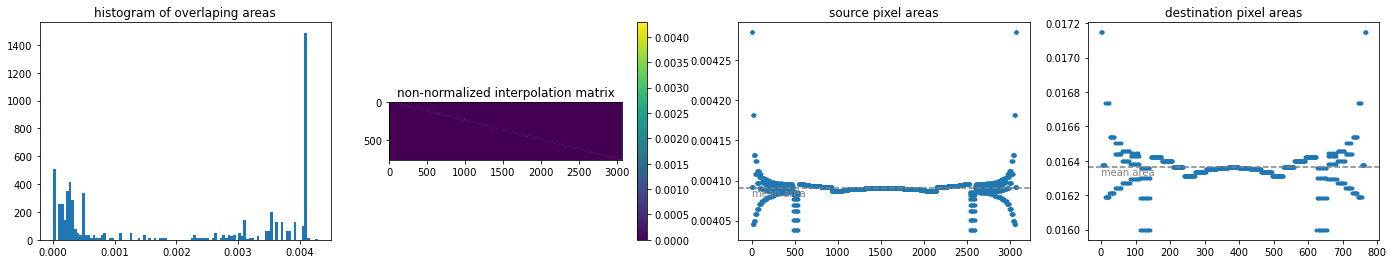

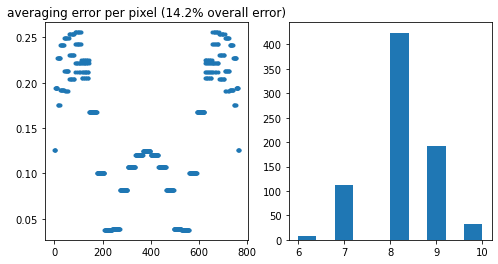

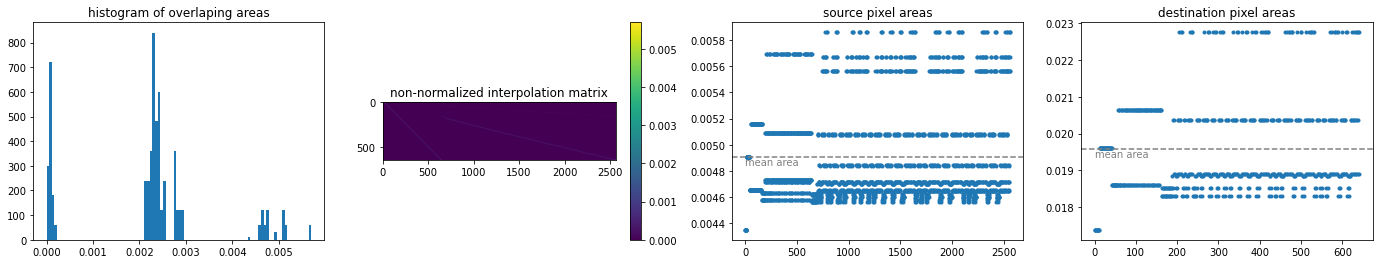

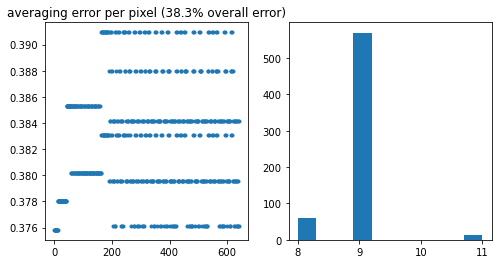

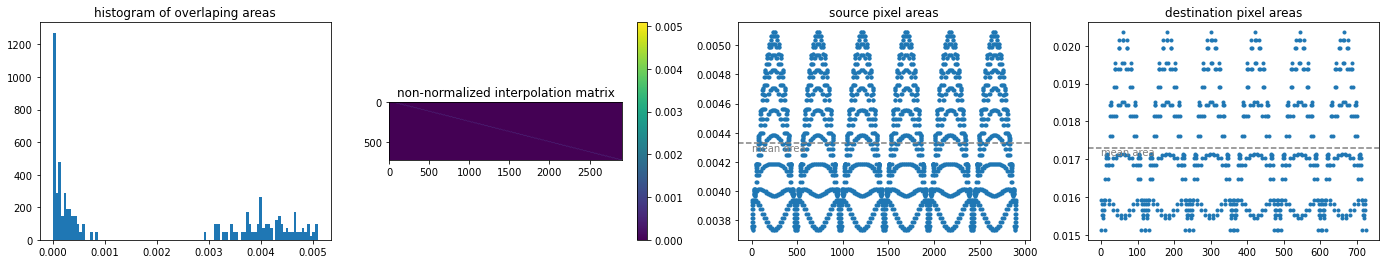

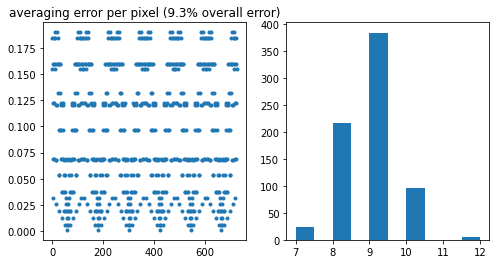

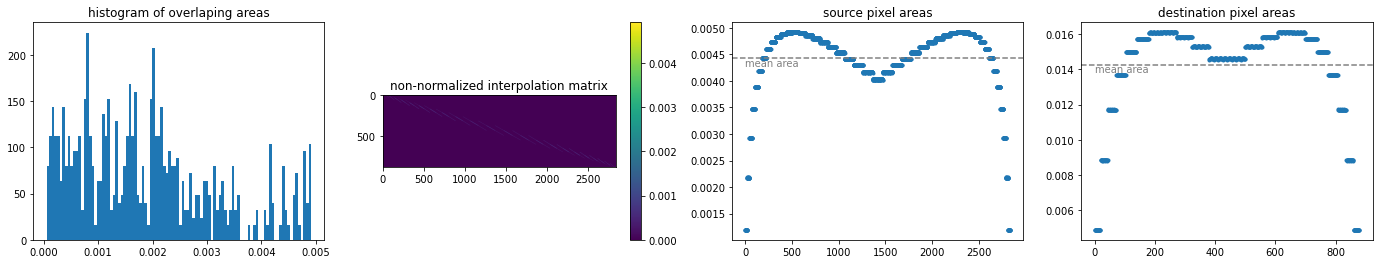

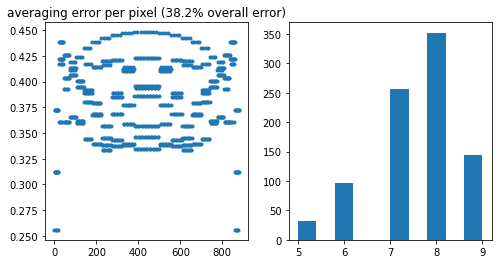

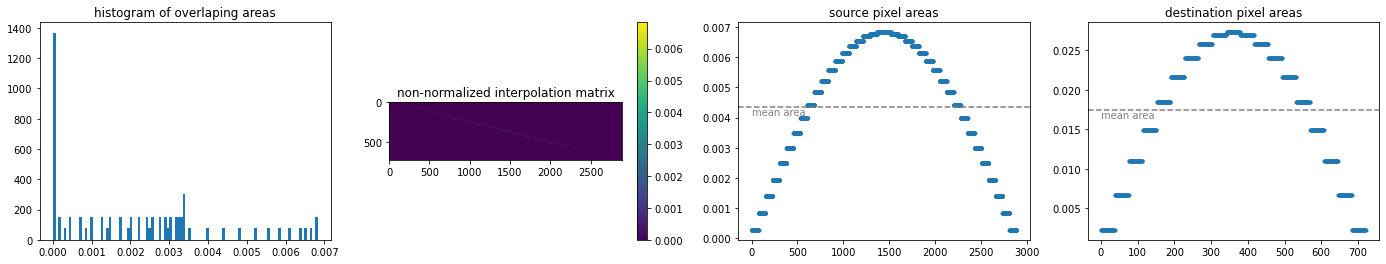

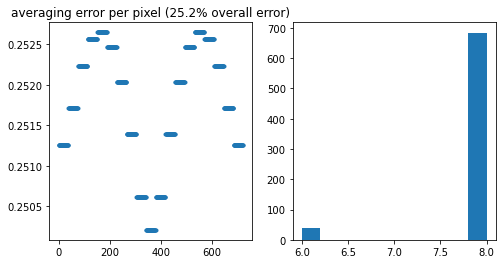

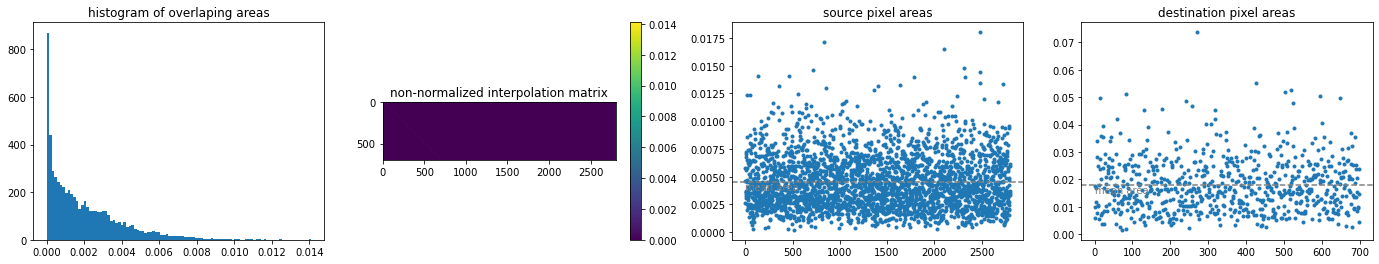

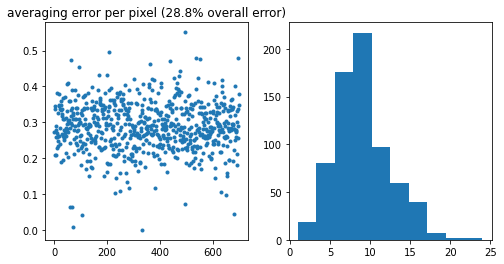

In [26]:
for sampling in samplings.values():
    weights = build_interpolation_matrix(sampling[0], sampling[1])
    plot_interpolation_matrix(weights)
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    plot_inversion_error(*build_pooling_matrices(weights), axes[0])
    axes[1].hist((weights > 0).sum(1));
    print('averaging over {:.1f} pixels, ({} non-zeros, {:.2%} sparsity)'.format(weights.nnz / weights.shape[0], weights.nnz, weights.nnz / np.prod(weights.shape)))